## Massive Study
In this notebook, we increase the scope of to many more flows for specific tasks.
We hope to find more similar model parameters in this study than more fine-grained ones.


In [1]:
from openml import datasets, tasks, runs, flows, setups, config, evaluations
from workloadoptimization.essentials import Component, ExperimentObject, ExperimentGraph, ExperimentParser
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import uuid
import networkx as nx
import sklearn
from networkx.drawing.nx_agraph import graphviz_layout
from openmlstudy14.preprocessing import ConditionalImputer
%matplotlib inline


config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))

In [49]:
TASK_IDS = [31]
#openMLTask = tasks.get_task(task_id=31)
#openMLRuns = runs.list_runs(task=TASK_IDS)
#runDF = pd.DataFrame.from_dict(openMLRuns, orient='index')
# ALL_FLOW_IDS has the list of all the flows for TASK_ID = 31
#ALL_FLOW_IDS = runDF['flow_id'].unique()

In [80]:
ALL_OPENML_FLOWS = pd.DataFrame.from_dict(flows.list_flows(), orient='index')

In [81]:
FLOW_IDS = ALL_OPENML_FLOWS[ALL_OPENML_FLOWS.apply(lambda x:x[4] in ALL_FLOW_IDS and x[0].startswith('sklearn'), axis=1)].id

In [77]:
import pickle
def getTopRuns(numberOfRuns, pipeline, task):
    openMlEvaluations = evaluations.list_evaluations('predictive_accuracy', task= [task], flow = [pipeline])
    evaluationData = pd.DataFrame.from_dict(openMlEvaluations, orient='index')
    evaluationData['accuracy'] = evaluationData.apply(lambda eva: eva.values[0].value, axis = 1)
    evaluationData['run_id'] = evaluationData.apply(lambda eva: eva.values[0].run_id, axis = 1)
    # extracting the top ''numberOfRuns' runs
    topRuns = evaluationData.sort_values('accuracy',ascending=False)
    if (numberOfRuns>0):
        topRuns = topRuns[0:numberOfRuns]
    # retreiving the run objects from the top runs
    openMLRuns = runs.list_runs(task=[task], flow=[pipeline])
    experiments = pd.DataFrame.from_dict(openMLRuns,orient='index')
    Experiment = experiments.merge(topRuns,on='run_id').drop(columns=['uploader',0])
    # TODO: This is the limit on the api size, I should fix it to make calls in batches
    Setup = pd.DataFrame.from_dict(setups.list_setups(setup=Experiment.setup_id[0:500],size = 500 ), orient='index').reset_index()
    Setup.columns=['id', 'setup']

    return pd.merge(Setup, Experiment, how = 'inner', left_on='id', right_on='setup_id').drop(columns = ['id','setup_id'])[['run_id','task_id','flow_id', 'accuracy','setup']]
def extractExperiments(filePath, taskIds, flowIds):
    if os.path.isfile(filePath):
        return pd.read_pickle(filePath)
    frames = []
    for t in taskIds:
        for f in flowIds:
            frames.append(getTopRuns(100000,f,t))
    Experiments = pd.concat(frames).reset_index(drop=True)
    Experiments.to_pickle(filePath)
    return Experiments

# This is time consuming, so it is better to persist the list of the runs to disk
# If you are changing the tasks or flow ids, remember to change the name of the file 
Experiments = extractExperiments('meta/massive-study-picked-experiment-task-31', TASK_IDS, FLOW_IDS)


In [106]:
# ProblematicFlows = [4830,4834,4835]
#FLOW_IDS = FLOW_IDS.drop(ProblematicFlows)
#FilteredExperiments = Experiments[Experiments.apply(lambda e : e[2] not in ProblematicFlows, axis=1)]
FilteredExperiments[FilteredExperiments.flow_id == 4835]

,run_id,task_id,flow_id,accuracy,setup


In [108]:
OPENML_FLOWS = {}
for f in FLOW_IDS:
    try:
        #print f
        fl = flows.get_flow(f)
        OPENML_FLOWS[f] = fl 
    except:
        print 'error for {}'.format(f)
#parser = ExperimentParser()
#experimentObjects = parser.extractOpenMLFlows(Experiments, OPENML_FLOWS)

In [231]:
parser = ExperimentParser()
experimentObjects = parser.extractOpenMLFlows(FilteredExperiments, OPENML_FLOWS)

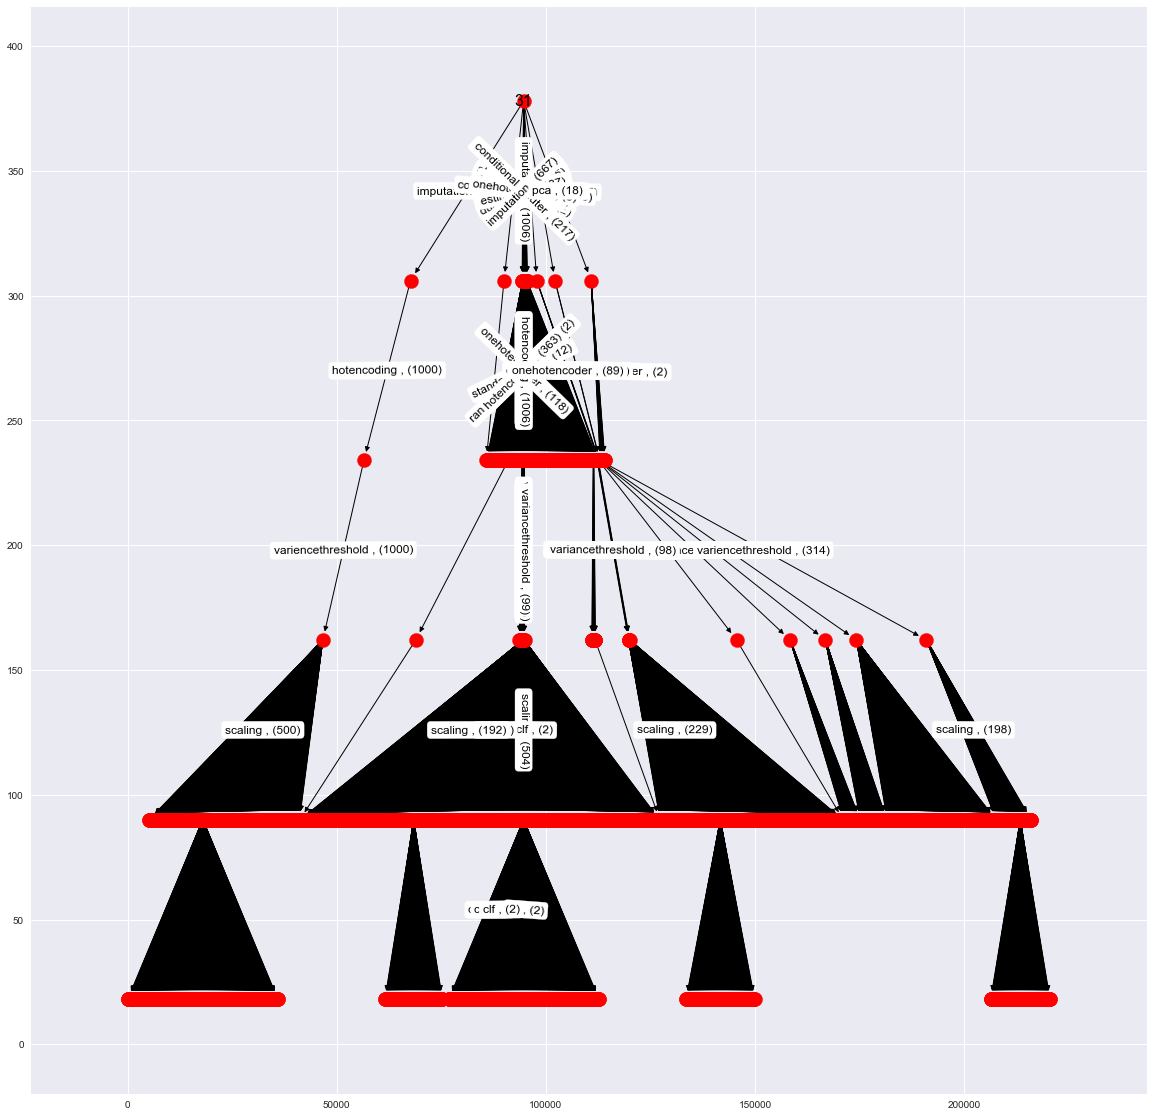

In [230]:
experimentGraph = ExperimentGraph()
for ex in experimentObjects:
    experimentGraph.insertExperimentObject(ex)
# Visualize the Graph
def drawGraph(graph):
    def prettyLabel(edgeLabel):
        if (edgeLabel['weight'] <= 1):
            return ''
        else:
            return '{} , ({})'.format(edgeLabel['name'], edgeLabel['weight'])
    edge_labels = dict([((u,v,),prettyLabel(d)) for u,v,d in graph.edges(data=True)])
    labels = dict({k for k in graph.nodes(data ='label')})
    pos = graphviz_layout(graph, prog='dot')
    gp = plt.figure(figsize=(20, 20))
    nx.draw_networkx_edge_labels(graph, pos, alpha=1, edge_labels=edge_labels, font_size=12)
    nx.draw_networkx_nodes(graph, pos, node_size=200)
    nx.draw_networkx_edges(graph, pos, alpha=1,arrows=True)
    nx.draw_networkx_labels(graph,pos,labels=labels, font_size=16)
    gp.savefig("graph.png")

drawGraph(experimentGraph.graph)

## Manually fix the order of the pipeline components

In [232]:
flowsToCheck = {}
for k,f in OPENML_FLOWS.iteritems():
    if len(f.components) > 1:
        flowsToCheck[k] = f
correctOrdering = {}

In [233]:
correctOrdering[5804]=[u'pca', u'randomforestclassifier']
correctOrdering[5909]=[u'imputer' ,u'pca', u'randomforestclassifier']
correctOrdering[5910]=[u'imputer' ,u'pca', u'gradientboostingclassifier']
correctOrdering[5913]=[u'imputer' ,u'pca', u'polynomialfeatures', u'randomforestclassifier']
correctOrdering[5914]=[u'imputer' ,u'kernelpca', u'randomforestclassifier']
correctOrdering[5981]=[u'dualimputer' ,u'standardscaler', u'logisticregression']
correctOrdering[5983]=[u'dualimputer' ,u'standardscaler', u'svc']
correctOrdering[5987]=[u'dualimputer', u'randomforestclassifier']
correctOrdering[5995]=[u'standardscaler', u'pca', u'randomforestclassifier']
correctOrdering[6223]=[u'dualimputer', u'onehotencoder', u'randomforestclassifier']
correctOrdering[6268]=[u'onehotencoder', u'randomforestclassifier']
correctOrdering[6269]=[u'standardscaler', u'svc']
correctOrdering[6334]=[u'standardscaler', u'logisticregression']
correctOrdering[6946]=[u'imputation', u'hotencoding', u'variencethreshold', u'classifier']
correctOrdering[6954]=[u'imputation', u'hotencoding', u'variencethreshold', u'classifier']
correctOrdering[6958]=[u'imputation', u'hotencoding', u'variencethreshold', u'classifier']
correctOrdering[6969]=[u'imputation', u'hotencoding', u'variencethreshold', u'classifier']
correctOrdering[7694]=[u'imputation', u'hotencoding', u'variencethreshold', u'classifier']
correctOrdering[7717]=[u'imputation', u'hotencoding', u'variencethreshold', u'classifier']
correctOrdering[8315]=[u'imputation', u'hotencoding', u'variencethreshold', u'clf']
correctOrdering[8317]=[u'imputation', u'hotencoding', u'variencethreshold',u'scaling', u'clf']
correctOrdering[8325]=[u'imputer', u'estimator']
correctOrdering[8330]=[u'imputation', u'hotencoding', u'variencethreshold',u'scaling', u'classifier']
correctOrdering[8351]=[u'imputation', u'hotencoding', u'variencethreshold', u'clf']
correctOrdering[8353]=[u'imputation', u'hotencoding', u'variencethreshold',u'scaling', u'clf']
correctOrdering[8568]=[u'conditionalimputer', u'onehotencoder', u'variancethreshold',u'randomforestclassifier']

In [234]:
def findComponentByName(name, components):
    for c in components:
        if c.name == name:
            return c
    print 'ERROR: cannot find the name {} in components'.format(name)
        
for e in experimentObjects:
    if correctOrdering.has_key(e.flow) :
        fixedComponents = []
        for co in correctOrdering[e.flow]:
            fixedOrder = findComponentByName(co, e.components)
            fixedComponents.append(fixedOrder)
        e.components = fixedComponents
        

## Check the repeition on leaf nodes (model training)

In [236]:
mlModels = [node for node in experimentGraph.graph.nodes() if experimentGraph.graph.out_degree(node) == 0 and experimentGraph.graph.in_degree(node) ==1]

In [238]:
len(mlModels)

4947

In [246]:

print 'Number of repetited pipeline execution= {}'.format(len(experimentObjects) - len(experimentGraph.graph.nodes()))
print 'Total number of pipelines = {}'.format(len(experimentObjects))
print 'ratio: {}'.format(float(len(experimentObjects) - len(experimentGraph.graph.nodes()))/len(experimentObjects))

Number of repetited pipeline execution= 273
Total number of pipelines = 5286
ratio: 0.0516458569807
